# Analisa Time Series

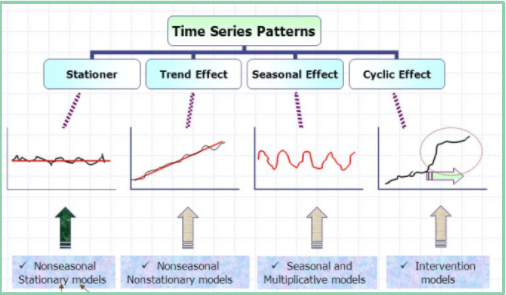


## Import Library dan Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv

--2021-11-17 10:29:48--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1834 (1.8K) [text/plain]
Saving to: ‘monthly-car-sales.csv.2’

monthly-car-sales.c 100%[===================>]   1.79K  --.-KB/s    in 0s      

2021-11-17 10:29:48 (26.6 MB/s) - ‘monthly-car-sales.csv.2’ saved [1834/1834]



In [9]:
#Load data
data = pd.read_csv('monthly-car-sales.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587

 Data Types:
Month    object
Sales     int64
dtype: object


In [10]:
#Mengubah tanggal menjadi index
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '1968-03-01', '1968-04-01', '1968-05-01', '1968-06-01',
               '1968-07-01', '1968-08-01', '1968-09-01', '1968-10-01',
               '1968-11-01', '1968-12-01'],
              dtype='datetime64[ns]', name='Month', length=108, freq=None)

In [11]:
data

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587
...,...
1968-08-01,16722
1968-09-01,14385
1968-10-01,21342


In [18]:
#convert to time series:
ts = data['Sales']
ts.head(10)

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
1960-06-01    13791
1960-07-01     9498
1960-08-01     8251
1960-09-01     7049
1960-10-01     9545
Name: Sales, dtype: int64

## Ploting data


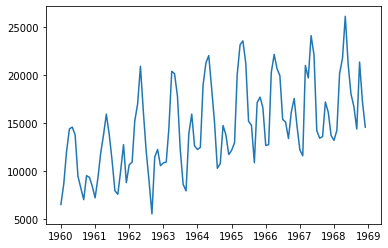

In [19]:
plt.plot(ts)

## Uji Stasioneritas

Ho : data tidak stasioner

Ha : data stasioner

In [20]:
#Membuat fungsi untuk uji stasioneritas
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

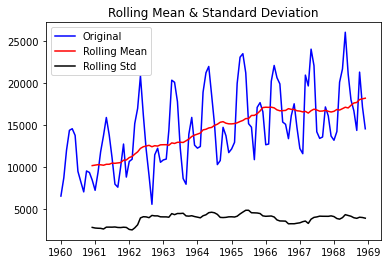

Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [21]:
#Menguji data
test_stationarity(ts)

Terlihat meansnya terus berubah sehingga tidak bisa disebut stasioner. Menurut uji Dickey-Fuller, p-value = 0.99 > 0.05, sehingga Ho gagal ditolak, data tidak stasioner. Nah kita harus melakukan transformasi atau differencing

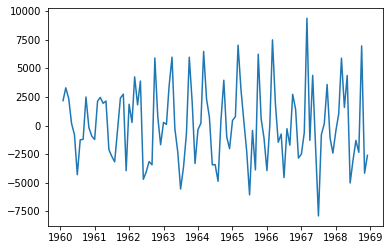

In [22]:
#Melakukan differencing pertama
ts_diff_1 = ts - ts.shift()
ts_diff_1 = ts_diff_1.dropna()
plt.plot(ts_diff_1)

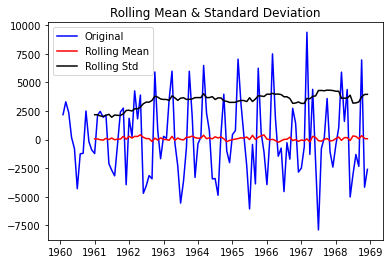

Results of Dickey-Fuller Test:
Test Statistic                -6.199799e+00
p-value                        5.844753e-08
#Lags Used                     1.100000e+01
Number of Observations Used    9.500000e+01
Critical Value (1%)           -3.501137e+00
Critical Value (5%)           -2.892480e+00
Critical Value (10%)          -2.583275e+00
dtype: float64


In [34]:
test_stationarity(ts_diff_1)

Terlihat masih belum stasioner, boleh coba differencing sekali lagi atau coba lanjutkan ke transformasi log

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


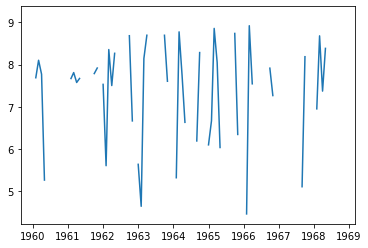

In [23]:
#Mencoba melakukan transformasi log
ts_log_dif = np.log(ts_diff_1)
plt.plot(ts_log_dif)

Ternyata tidak lebih baik. Sekarang coba data awal yang ditransformasi log

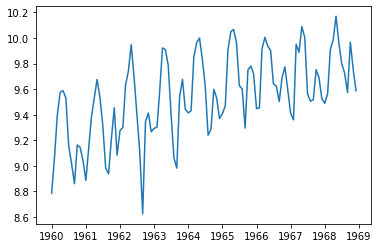

In [40]:
#Mencoba melakukan transformasi log
ts_log = np.log(ts)
plt.plot(ts_log)

Masih belum stasioner, tetapi secara varians terlihat lebih baik. Sekarang coba data yang ini didifferencing

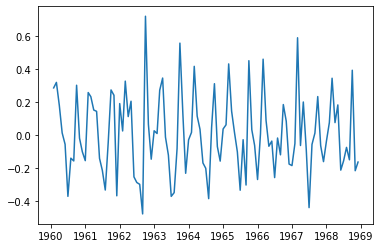

In [41]:
#Melakukan differencing setelah transform log
ts_log_1 = ts_log - ts_log.shift()
ts_log_1 = ts_log_1.dropna()
plt.plot(ts_log_1)

Sepertinya sudah stasioner, sekarang coba uji Dickey-Fuller supaya lebih meyakinkan

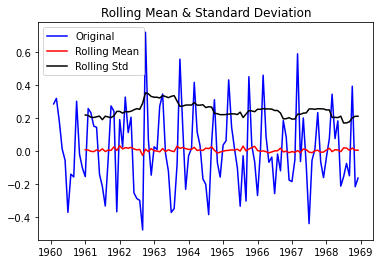

Results of Dickey-Fuller Test:
Test Statistic                 -4.193835
p-value                         0.000675
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [42]:
test_stationarity(ts_log_1)

Jika menggunakan alpha 10%, nilai p-value < alpha sehingga sudah memenuhi syarat stasioner. Jadi untuk mempersingkat waktu kita gunakan hasil ini dengan tingkat kepercayaan 90%.

## ACF & PACF

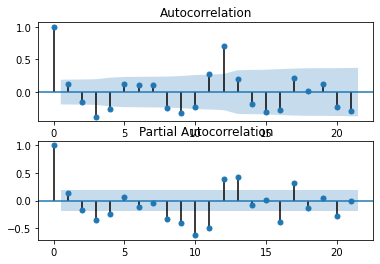

In [58]:
plt.figure()
plt.subplot(211)
plot_acf(ts_log_1, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_log_1, ax=plt.gca())
plt.show()

Terlihat bahwa keduanya cut off lag ke-1, lalu 4, lalu 8, ini menunjukkan pola seasonal (musiman) dengan orde 4. Sehingga kemungkinan modelnya


1. ARIMA(1, 1, 1) (p=1, d=1 karena sudah differencing sekali, q=1)
2. SARIMA(1, 1, 1)4, karena mencapai max/min tiap 4

Dan kombinasi lainnya dengan p=[1, 4, 8], d=1, q=[1, 4, 8]

## Membuat model ARIMA

In [35]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [49]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(ts_log.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.322
ARIMA(0, 0, 1) RMSE=0.228
ARIMA(0, 0, 4) RMSE=0.202
ARIMA(0, 1, 0) RMSE=0.207
ARIMA(0, 1, 1) RMSE=0.210
ARIMA(0, 1, 2) RMSE=0.189
ARIMA(0, 1, 3) RMSE=0.184
ARIMA(0, 1, 4) RMSE=0.181
ARIMA(1, 0, 0) RMSE=0.196
ARIMA(1, 0, 1) RMSE=0.196
ARIMA(1, 0, 2) RMSE=0.192
ARIMA(1, 0, 3) RMSE=0.192
ARIMA(1, 0, 4) RMSE=0.190
ARIMA(1, 1, 0) RMSE=0.210
ARIMA(1, 1, 2) RMSE=0.186
ARIMA(1, 1, 3) RMSE=0.183
ARIMA(1, 1, 4) RMSE=0.188
ARIMA(2, 0, 0) RMSE=0.199
ARIMA(2, 0, 2) RMSE=0.190
ARIMA(2, 1, 0) RMSE=0.211
Best ARIMA(0, 1, 4) RMSE=0.181


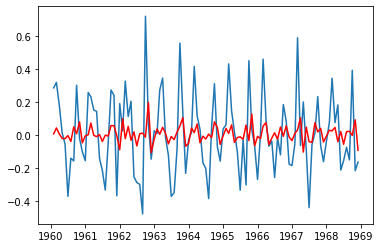

In [54]:
model_ARIMA = ARIMA(ts_log, order=(2,1,0))
results_ARIMA = model_ARIMA.fit(disp=-1)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
plt.plot(ts_log_1)             
plt.plot(predictions_ARIMA_diff, color='red')               #fitting dengan data yang udah difference sekali dan log

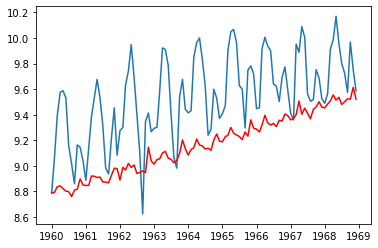

In [55]:
predictions_ARIMA_diff_cum_sum = predictions_ARIMA_diff.cumsum()                                
predictions_ARIMA_log = pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cum_sum,fill_value=0)
plt.plot(ts_log)             
plt.plot(predictions_ARIMA_log, color='red')               #fitting dengan data yang ditransformasi log

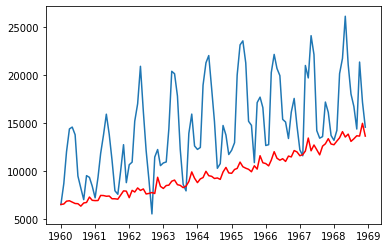

In [33]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA, color='red')                    #fitting dengan data asli

In [ ]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Wed, 17 Nov 2021   AIC                           -287.281
Time:                        02:38:17   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.#Passengers    -0.8946      0.039    -23.127      0.000      -0.970      -0.819
ma.L1.D.#Passengers    -1.8270      0.036    -51.303      0.000      -1.897      -1.757
ma.L2.D.#Passengers     0.9245      0.036     25.568      0.000       0.854       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9106           -0.5372j            1.0573           -0.0848
AR.2            0.9106           +0.5372j            1.0573            0.0848
MA.1            0.9881           -0.3245j            1.0400           -0.0505
MA.2            0.9881           +0.3245j            1.0400            0.0505
-----------------------------------------------------------------------------
"""

## Kombinasi Model dengan Seasonal dan Trend

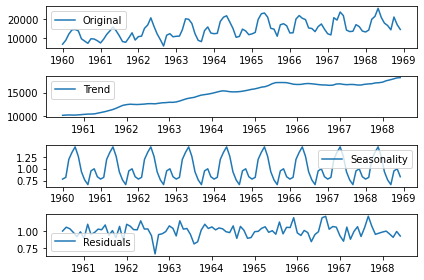

In [56]:
decomposition = seasonal_decompose(ts, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [59]:
train_size = int(len(ts) * 0.7)               #data trainingnya 70%
train, test = ts_log[:train_size], ts_log[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in range(len(test)):
		model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,3))
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])

# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)

0.19878668734805396


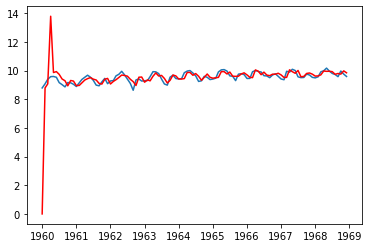

In [60]:
#Bikin model SARIMA
model_sarima = SARIMAX(ts_log, order=(1,1,1), seasonal_order=(1,1,1,3))
results_SARIMA = model_sarima.fit(disp=-1)
predictions_SARIMA_diff = pd.Series(results_SARIMA.fittedvalues,copy=True)
plt.plot(ts_log)             
plt.plot(predictions_SARIMA_diff, color='red')               #fitting dengan data log

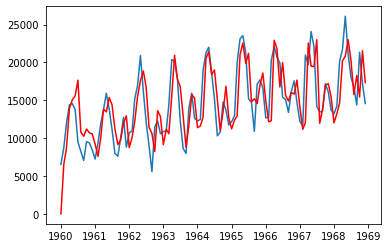

In [61]:
#SARIMA + trend untuk data asli
model_sarima_trend = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,3), trend='t')
results_SARIMA_t = model_sarima_trend.fit(disp=-1)
predictions_SARIMA_diff_t = pd.Series(results_SARIMA_t.fittedvalues,copy=True)
plt.plot(ts)             
plt.plot(predictions_SARIMA_diff_t, color='red')               #fitting dengan data

In [62]:
results_SARIMA_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 3)   Log Likelihood                -986.087
Date:                           Wed, 17 Nov 2021   AIC                           1984.173
Time:                                   11:03:27   BIC                           2000.040
Sample:                               01-01-1960   HQIC                          1990.601
                                    - 12-01-1968                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0118      0.047     -0.250      0.802      -0.105       0.081
ar.L1          0.9985      0.020     50.658      0.000       0.960       1.037
ma.L1         -0.9943      0.127     -7.818      0.000      -1.244      -0.745
ar.S.L3       -0.4392      0.128     -3.423      0.001      -0.691      -0.188
ma.S.L3       -0.9783      0.127     -7.724      0.000      -1.227      -0.730
sigma2      9.848e+06   1.07e-08   9.21e+14      0.000    9.85e+06    9.85e+06
===================================================================================
Ljung-Box (Q):                      211.77   Jarque-Bera (JB):                 3.37
Prob(Q):                              0.00   Prob(JB):                         0.19
Heteroskedasticity (H):               1.96   Skew:                             0.32
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+30. Standard errors may be unstable.
"""

## Membuat prediksi

In [ ]:
#dengan model ARIMA(2,1,2)
predict_dif = results_ARIMA.predict(start=144,end=156)
predictions_dif_cum_sum = predict_dif.cumsum()                   #prediksi differencingnya
pred_log = [ts_log[-1]]
for i, j in enumerate(predictions_dif_cum_sum):                  #prediksi data lognya
  a = pred_log[i] + j
  pred_log.append(a)
predict_exp = pd.Series(np.exp(pred_log[1:]), index=predict_dif.index)  #prediksi data aslinya
print(predict_exp)

1961-01-01     443.871029
1961-02-01     482.954612
1961-03-01     564.492410
1961-04-01     706.209885
1961-05-01     928.094966
1961-06-01    1246.758147
1961-07-01    1665.237533
1961-08-01    2166.114515
1961-09-01    2719.599596
1961-10-01    3308.636390
1961-11-01    3957.030397
1961-12-01    4746.085171
1962-01-01    5822.053630
Freq: MS, dtype: float64


In [64]:
#prediksi dengan SARIMA+trend
pred_2 = results_SARIMA_t.predict(start=144,end=156)
print(pred_2)

1972-01-01   -15218.184452
1972-02-01   -16497.367075
1972-03-01   -18091.471546
1972-04-01   -19150.969052
1972-05-01   -20520.447893
1972-06-01   -22205.891104
1972-07-01   -23357.875237
1972-08-01   -24820.802451
1972-09-01   -26600.843530
1972-10-01   -27848.538266
1972-11-01   -29408.380061
1972-12-01   -31286.466730
1973-01-01   -32633.363680
Freq: MS, dtype: float64
